In [2]:
#Import library

%matplotlib inline
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt
import math

import keras
from keras.layers import (Input, Activation, Conv3D, Dense, Dropout, Flatten, 
                          MaxPooling3D, BatchNormalization, AveragePooling3D, 
                          Reshape, Lambda, GlobalAveragePooling3D, Concatenate,
                          ReLU, Add)

from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.utils.layer_utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from keras.backend import set_session

from keras.callbacks import CSVLogger

from keras.utils.layer_utils import get_source_inputs


In [3]:
def plot_history(history, result_dir):
    '''
    Plots the accuracy and loss graphs of train and val and saves them.
    '''

    plt.plot(history.history['accuracy'], marker='.')
    plt.plot(history.history['val_accuracy'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
    plt.savefig(os.path.join(result_dir, 'model_accuracy.png'))
    plt.show()

    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(os.path.join(result_dir, 'model_loss.png'))
    plt.show();

In [4]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename):
        
        frames = []
        index = len(os.listdir(filename)) // self.depth
        images = os.listdir(filename)[::index]
        images = images[0:25]
        images.sort()

        for img in images:

            img_path = os.path.join(filename, img)
            frame = cv2.imread(img_path)
            frame = cv2.resize(frame, (self.height, self.width))
            frames.append(frame)

        return np.array(frames) / 255.0

In [5]:
def preprocess(video_dir, result_dir, nb_classes = 101, img_size = 224, frames = 25):
    '''
    Preprocess the videos into X and Y and saves in npz format and 
    computes input shape
    '''

    img_rows, img_cols  = img_size, img_size

    channel = 3

    files = os.listdir(video_dir)
    files.sort()

    if '.ipynb_checkpoints' in files:
        files.remove('.ipynb_checkpoints')

    X = []
    labels = []
    labellist = []

    # Obtain labels and X
    for filename in files:

        name = os.path.join(video_dir, filename)
        
        for v_files in os.listdir(name):
            
            v_file_path = os.path.join(name, v_files)
            label = filename
            if label not in labellist:
                if len(labellist) >= nb_classes:
                    continue
                labellist.append(label)
            labels.append(label)
            X.append(v_file_path)

    if not os.path.isdir(result_dir):
        os.makedir(result_dir)
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{} {}\n'.format(i, labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
                
    Y = np_utils.to_categorical(labels, nb_classes)

    print('X_shape:{}\tY_shape:{}'.format(len(X), Y.shape))

    input_shape = (frames, img_rows, img_cols, channel)

    return X, Y, input_shape

In [6]:
%run models/slowfast.py

def resnet50(inputs, **kwargs):
    model = SlowFast_body(inputs, [3, 4, 6, 3], bottleneck, **kwargs)
    return model

In [8]:
class batchGenerator(keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, vid3d):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.vid3d = vid3d

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = []

        for video in self.x[idx * self.batch_size:(idx + 1) * self.batch_size]:
            batch_x.append(self.vid3d.video3d(video))

        batch_x = np.array(batch_x)
        batch_x = batch_x.astype('float32')
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y

In [11]:
def main(video_dir, result_dir, nb_classes = 101, batch_size = 32, epochs = 30, img_size = 224, frames = 25):

    X, Y, input_shape = preprocess(video_dir, result_dir, nb_classes, img_size, 
                                   frames)

    print("Input Shape = ", input_shape)

    vid3d = Videoto3D(img_size, img_size, frames)

    
    ## For Slowfast model ##
    x = Input(shape = input_shape)
    model = resnet50(x, num_classes=nb_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
                  metrics=['accuracy'])
    
    
    model.summary()

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.15, shuffle = True)
    
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train, Y_train, test_size=0.15, shuffle = True)

    print("X_train.shape = ", len(X_train))
    print("X_val.shape = ", len(X_val))
    print("X_test.shape = ", len(X_test))

    # MODEL CHECK POINTS #

    csv_logger = CSVLogger("C:/Users/THE GAMER/Desktop/C_1/output/slowfast_model_history_log.csv", append=True)

    filepath="C:/Users/THE GAMER/Desktop/C_1/output/slowfast-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
    callbacks_list = [checkpoint, csv_logger]

    history = model.fit(batchGenerator(X_train, Y_train, batch_size, vid3d), steps_per_epoch = math.ceil(len(X_train) / batch_size), 
                                  validation_data = batchGenerator(X_val, Y_val, batch_size, vid3d), validation_steps = math.ceil(len(X_val) / batch_size), 
                                  epochs = epochs, verbose = 1, callbacks=callbacks_list, initial_epoch = 0)

    model_json = model.to_json()
    
    if not os.path.isdir(result_dir):
        os.makedir(result_dir)
    with open(os.path.join(result_dir, 'slowfast.json'), 'w') as json_file:
        json_file.write(model_json)
    
    model.save_weights(os.path.join(result_dir, 'slowfast_finalweights.hdf5'))

    model.save("slowfast_finalmodel.hdf5")

    loss, acc = model.evaluate(batchGenerator(X_test, Y_test, batch_size, vid3d),
                               steps = math.ceil(len(X_test) / batch_size), verbose = 1)
    
    plot_history(history, result_dir)

    print('Test loss:', loss)
    print('Test accuracy:', acc)

    return history, model

X_shape:1828	Y_shape:(1828, 4)
Input Shape =  (25, 224, 224, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 data_fast (Lambda)             (None, 13, 224, 224  0           ['input_2[0][0]']                
                                , 3)                                                              
                                                                                                  
 data_slow (Lambda)             (None, 2, 224, 224,  0           ['input_2[0][0]']                
                            

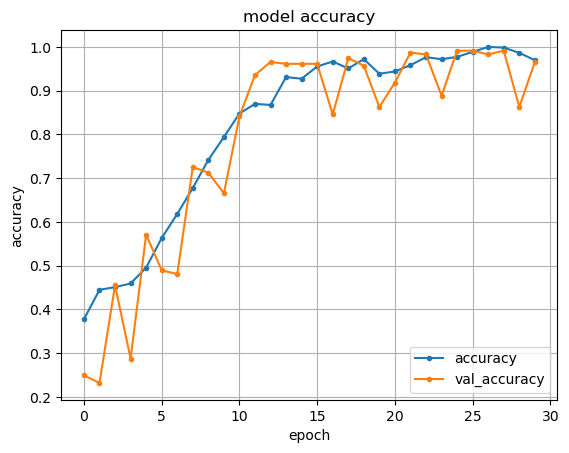

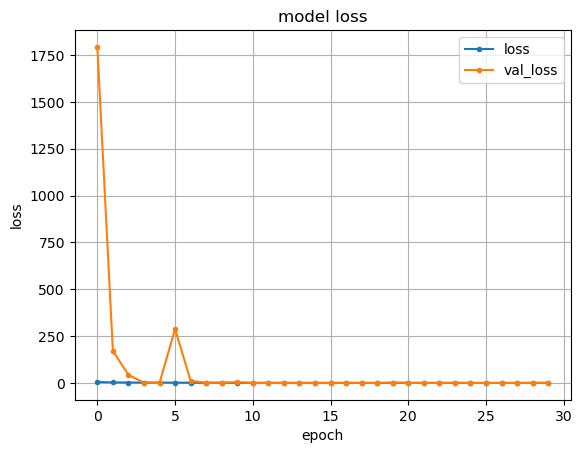

Test loss: 0.05595669150352478
Test accuracy: 0.9818181991577148


In [12]:
## TRAIN MODEL ##

history, model = main(video_dir = 'C:/Users/THE GAMER/Desktop/C_1/DCSASS Dataset', result_dir = 'C:/Users/THE GAMER/Desktop/C_1/output', nb_classes = 4, batch_size = 8, epochs = 30, img_size = 224, frames = 25)

In [13]:
def frames_from_video(video_dir, nb_frames = 25, img_size = 224):

    # Opens the Video file
    cap = cv2.VideoCapture(video_dir)
    i=0
    frames = []
    while(cap.isOpened() and i<nb_frames):
        ret, frame = cap.read()
        if ret == False:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame)
        i+=1

    cap.release()
    cv2.destroyAllWindows()
    return np.array(frames) / 255.0

In [14]:
def predictions(video_dir, model, nb_frames = 25, img_size = 224):

    X = frames_from_video(video_dir, nb_frames, img_size)
    X = np.reshape(X, (1, nb_frames, img_size, img_size, 3))
    
    predictions = model.predict(X)
    preds = predictions.argmax(axis = 1)

    classes = []
    with open(os.path.join('output', 'classes.txt'), 'r') as fp:
        for line in fp:
            classes.append(line.split()[1])

    for i in range(len(preds)):
        print('Prediction - {} -- {}'.format(preds[i], classes[preds[i]]))

In [26]:
## MAKE PREDICTIONS ##

predictions(video_dir = 'C:/Users/THE GAMER/Desktop/C_1/test/Shoplifting022_x264_10.mp4', model = reconstructed_model, nb_frames = 25, img_size = 224)

1/1 [==============================] - 2s 2s/step
Prediction - 1 -- Shoplifting


In [24]:
## LOAD MODEL ##

model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [25]:
reconstructed_model = keras.models.load_model("my_model")